In [57]:
import pandas as pd
import numpy as np
import torch.multiprocessing as mp
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder, MinMaxScaler
from LEN_Scorer import Scorer
from matplotlib import pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import PolynomialFeatures
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed
from scipy.interpolate import interp1d

import copy

In [58]:
mimicDF = pd.read_csv("../LEN_Test/data/TimeSeries.csv")
targetDF = mimicDF['Mortality14Days']
mimicDF = mimicDF.drop(['Mortality14Days'], axis=1)
mimicDF

,PatientID,ALT,AST,Admit Ht,Albumin,Arterial BP Mean,Arterial BP [Diastolic],Arterial BP [Systolic],Arterial PaCO2,Arterial PaO2,...,SVI,SVR,SVRI,SaO2,Sodium,SpO2,SvO2,Temperature C,Total Bili,WBC
0,178177,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,178177,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,178177,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,178177,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,178177,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47083,159740,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47084,159740,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47085,159740,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47086,159740,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [59]:
mimicDF.describe()

,PatientID,ALT,AST,Admit Ht,Albumin,Arterial BP Mean,Arterial BP [Diastolic],Arterial BP [Systolic],Arterial PaCO2,Arterial PaO2,...,SVI,SVR,SVRI,SaO2,Sodium,SpO2,SvO2,Temperature C,Total Bili,WBC
count,47088.000000,484.000000,481.000000,705.000000,245.000000,31415.000000,31503.000000,31504.000000,8601.000000,8582.000000,...,12981.000000,14768.000000,14714.000000,4352.000000,2485.000000,32961.000000,85.000000,26516.000000,331.000000,2118.000000
mean,151079.910805,630.123967,954.301455,67.382553,2.721633,77.058157,57.226709,117.544502,40.565399,152.720982,...,33.217492,987.290546,1917.421073,96.799012,138.022942,97.267665,64.988235,37.235334,2.529305,12.747691
std,29378.613191,1245.805613,2384.326867,5.448469,0.584693,14.324177,11.197415,21.311674,7.078312,92.767596,...,10.474703,363.504762,608.801780,2.659592,5.435978,3.083466,10.518118,1.399548,3.004787,5.523420
min,100059.000000,3.000000,3.000000,48.000000,1.400000,0.000000,0.000000,0.000000,15.000000,7.470000,...,0.000000,0.000000,0.000000,42.000000,1.210000,0.000000,43.000000,0.000000,0.000000,1.900000
25%,126241.000000,25.000000,49.000000,64.000000,2.400000,68.000000,50.000000,103.000000,36.000000,90.000000,...,26.168200,737.500000,1494.877533,96.000000,136.000000,96.000000,58.000000,36.900002,0.600000,9.000000
50%,151857.000000,97.000000,137.000000,68.000000,2.700000,75.000000,56.000000,115.000000,40.000000,118.000000,...,31.460699,931.028503,1841.049988,97.000000,138.000000,98.000000,65.000000,37.299999,1.400000,11.900000
75%,176484.000000,554.750000,797.000000,70.000000,3.000000,84.000000,63.000000,129.000000,44.000000,174.750000,...,38.118801,1169.229980,2244.340088,98.000000,140.000000,100.000000,71.000000,37.700001,3.300000,15.500000
max,199998.000000,8100.000000,23060.000000,160.000000,4.400000,287.000000,191.000000,255.000000,91.000000,499.000000,...,179.212997,3784.620117,6000.000000,100.000000,164.000000,100.000000,100.000000,46.500000,16.400000,48.300000


In [60]:
print(f"There are {mimicDF['PatientID'].nunique()} unique patients in the dataset")

There are 1126 unique patients in the dataset


In [61]:
class Reading:

    def __init__(self, time, readingData):
        self.time = time
        self.readingData = readingData

    def __repr__(self):
        return f"Time_index: {self.time}\n Data: {self.readingData}"

In [62]:
class Patient:

    def __init__(self, patientID, data):
        self.patientID = patientID
        self.data = data


    def __repr__(self):
        return f"PatientID: {self.patientID}\n Readings: {self.data}"
    

In [63]:
for id in mimicDF['PatientID'].unique()[:1]:
    patientDF = mimicDF[mimicDF['PatientID'] == id]
    display(patientDF)

,PatientID,ALT,AST,Admit Ht,Albumin,Arterial BP Mean,Arterial BP [Diastolic],Arterial BP [Systolic],Arterial PaCO2,Arterial PaO2,...,SVI,SVR,SVRI,SaO2,Sodium,SpO2,SvO2,Temperature C,Total Bili,WBC
0,178177,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,178177,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,178177,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,178177,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,178177,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,178177,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,178177,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,178177,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,178177,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,178177,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [64]:
patients = []

for id in mimicDF['PatientID'].unique():
    patientDF = mimicDF[mimicDF['PatientID'] == id].drop(columns=['PatientID']).reset_index()
    patient = Patient(id, patientDF)
    patients.append(patient)

print(len(patients))

1126


In [65]:
print(patients[1])

PatientID: 110594
 Readings:     index  ALT  AST  Admit Ht  Albumin  Arterial BP Mean  \
0      48  NaN  NaN       NaN      NaN              84.0   
1      49  NaN  NaN       NaN      NaN              85.0   
2      50  NaN  NaN       NaN      NaN              84.0   
3      51  NaN  NaN       NaN      NaN              91.0   
4      52  NaN  NaN       NaN      NaN              68.0   
5      53  NaN  NaN       NaN      NaN              82.0   
6      54  NaN  NaN      68.0      NaN               NaN   
7      55  NaN  NaN       NaN      NaN              72.0   
8      56  NaN  NaN       NaN      NaN              68.0   
9      57  NaN  NaN       NaN      NaN              71.0   
10     58  NaN  NaN       NaN      NaN              70.0   
11     59  NaN  NaN       NaN      NaN              84.0   
12     60  NaN  NaN       NaN      NaN              85.0   
13     61  NaN  NaN       NaN      NaN              83.0   
14     62  NaN  NaN       NaN      NaN              82.0   
15     63  

In [66]:
cleaningDF = patients[0].data
cleaningDF.head()

,index,ALT,AST,Admit Ht,Albumin,Arterial BP Mean,Arterial BP [Diastolic],Arterial BP [Systolic],Arterial PaCO2,Arterial PaO2,...,SVI,SVR,SVRI,SaO2,Sodium,SpO2,SvO2,Temperature C,Total Bili,WBC
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [67]:
columnsToInterpolate = ['Glucose']

noInterpolation = 0

interpolatedPatients = patients.copy()

for patient in interpolatedPatients:
    try:
        patient.data[columnsToInterpolate] = patient.data[columnsToInterpolate].apply(lambda x: x.interpolate(method='polynomial', order=2))
    except ValueError:
        noInterpolation += 1
        continue

print(f"{noInterpolation}/{len(patients)} patients have no missing values")

65/1126 patients have no missing values


In [68]:
cleaningDF = patients[0].data[columnsToInterpolate]
cleaningDF

,Glucose
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
5,NaN
6,NaN
7,NaN
8,NaN
9,NaN


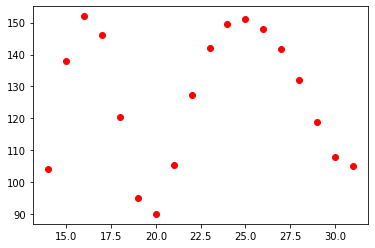

In [69]:
glucoseSeries = cleaningDF['Glucose']

generated = glucoseSeries.interpolate(method='polynomial', order=2)

# print(generated)
# for idx, value in enumerate(generated):
#     if str(glucoseSeries.iloc[idx]) != 'nan':
#         generated.iloc[idx]  = np.NaN

# print(generated)

plt.scatter(generated.index, generated, c='r')
# plt.scatter(glucoseSeries.index, glucoseSeries)

plt.show()

In [75]:
pd.set_option('display.max_rows', 1000)

In [98]:
staticPatients = []


for patient in patients:

    curr = {}

    df = patient.data

    curr['PatientID'] = patient.patientID
    curr['ALT'] = df['ALT'].max()
    curr['AST'] = df['AST'].max()
    curr['Admit Ht'] = df['Admit Ht'].max()
    curr['Albumin'] = df['Albumin'].min()
    curr['Arterial BP Mean'] = df['Arterial BP Mean'].min()
    curr['Arterial BP [Diastolic]'] = df['Arterial BP [Diastolic]'].min()
    curr['Arterial BP [Systolic]'] = df['Arterial BP [Systolic]'].min()
    curr['Arterial PaCO2'] = df['Arterial PaCO2'].min()
    curr['Arterial PaO2'] = df['Arterial PaO2'].min()
    curr['Arterial pH Max'] = df['Arterial pH'].max()
    curr['Arterial pH Min'] = df['Arterial pH'].min()
    curr['Urea'] = df['BUN'].min() * 0.357
    curr['CVP Min'] = df['CVP'].min()
    curr['CVP Max'] = df['CVP'].max()
    curr['CaO2'] = df['CaO2'].min()
    curr['Chloride'] = df['Chloride'].min()
    curr['Creatinine'] = df['Creatinine'].min()
    curr['Daily Weight'] = df['Daily Weight'].loc[df['Daily Weight'].first_valid_index()] / 2.205 if df['Daily Weight'].first_valid_index() is not None else None
    curr['Fibrinogen'] = df['Fibrinogen'].max()
    curr['Glucose Max'] = df['Glucose'].max()
    curr['Glucose Min'] = df['Glucose'].min()
    curr['Heart Rate Min'] = df['Heart Rate'].min()
    curr['Heart Rate Max'] = df['Heart Rate'].max()
    curr['Hamoglobin'] = df['Hemoglobin'].min()
    curr['INR'] = df['INR'].max()
    curr['Ionized Calcium'] = df['Ionized Calcium'].min()
    curr['LDH'] = df['LDH'].max()
    curr['Magnesium'] = df['Magnesium'].min()
    curr['NBP Mean'] = df['NBP Mean'].min()
    curr['NBP [Diastolic]'] = df['NBP [Diastolic]'].min()
    curr['NBP [Systolic]'] = df['NBP [Systolic]'].min()
    curr['PTT'] = df['PTT'].max()
    curr['Platelets'] = df['Platelets'].min()
    curr['Potassium Max'] = df['Potassium'].max()
    curr['Potassium Min'] = df['Potassium'].min()
    curr['Resp Rate (Spont) Min'] = df['Resp Rate (Spont)'].min()
    curr['Resp Rate (Spont) Max'] = df['Resp Rate (Spont)'].max()
    curr['SVI'] = df['SVI'].min()
    curr['SVRI Max'] = df['SVRI'].max()
    curr['SVRI Min'] = df['SVRI'].min()
    curr['SaO2'] = df['SaO2'].min()
    curr['Sodium Max'] = df['Sodium'].max()
    curr['Sodium Min'] = df['Sodium'].min()
    curr['SpO2'] = df['SpO2'].min()
    curr['SvO2 Max'] = df['SvO2'].max()
    curr['SvO2 Min'] = df['SvO2'].min()
    curr['Temperature C Max'] = df['Temperature C'].max()
    curr['Temperature C Min'] = df['Temperature C'].min()
    curr['Bilirubin'] = df['Total Bili'].max()
    curr['White Blood Cells Max'] = df['WBC'].max()
    curr['White Blood Cells Min'] = df['WBC'].min()

    staticPatients.append(curr)


staticPatientsDF = pd.DataFrame([x.values() for x in staticPatients], columns=curr.keys())

display(staticPatientsDF)

,PatientID,ALT,AST,Admit Ht,Albumin,Arterial BP Mean,Arterial BP [Diastolic],Arterial BP [Systolic],Arterial PaCO2,Arterial PaO2,...,Sodium Max,Sodium Min,SpO2,SvO2 Max,SvO2 Min,Temperature C Max,Temperature C Min,Bilirubin,White Blood Cells Max,White Blood Cells Min
0,178177,NaN,NaN,65.0,NaN,64.0,48.0,99.0,39.0,80.0,...,138.0,133.0,90.0,NaN,NaN,38.799999,35.700001,NaN,12.1,8.2
1,110594,NaN,NaN,68.0,NaN,68.0,42.0,96.0,42.0,83.0,...,NaN,NaN,92.0,NaN,NaN,38.200001,36.799999,NaN,NaN,NaN
2,157699,NaN,NaN,64.0,NaN,63.0,46.0,86.0,37.0,84.0,...,136.0,134.0,93.0,NaN,NaN,37.700001,36.500000,NaN,13.3,11.3
3,180230,NaN,NaN,70.0,NaN,57.0,46.0,77.0,31.0,65.0,...,137.0,131.0,93.0,NaN,NaN,38.299999,36.000000,NaN,12.6,12.6
4,165898,NaN,NaN,NaN,NaN,60.0,43.0,95.0,45.0,93.0,...,142.0,141.0,82.0,NaN,NaN,38.099998,37.200001,NaN,17.4,13.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1121,196597,NaN,NaN,NaN,NaN,54.0,36.0,88.0,37.0,82.0,...,NaN,NaN,93.0,NaN,NaN,38.500000,37.099998,NaN,NaN,NaN
1122,116726,NaN,NaN,62.0,NaN,48.0,40.0,78.0,30.0,105.0,...,137.0,133.0,68.0,NaN,NaN,37.200001,36.099998,NaN,21.3,17.6
1123,169975,NaN,NaN,62.0,NaN,64.0,50.0,77.0,32.0,56.0,...,145.0,142.0,91.0,NaN,NaN,39.700001,36.500000,NaN,13.7,11.1
1124,147451,11.0,48.0,NaN,NaN,55.0,42.0,80.0,35.0,61.0,...,140.0,140.0,93.0,NaN,NaN,38.099998,37.599998,4.1,9.9,9.9
